In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom, norm
from tqdm import tqdm
import pandas as pd

from protein_conformal.util import *
# from util import simplifed_venn_abers_prediction

In [2]:
data_path = '/groups/doudna/projects/ronb/conformal_backup/protein-conformal/data/pfam_new_proteins.npy'
data = np.load(data_path, allow_pickle=True)
print(len(data))
print(len(data[0]['S_i']))

1864
100000


## Look at distribution of $S_{ij}$ across retrieved hits

Text(0.5, 1.0, 'Protein-vec: Histogram of Similarity Scores')

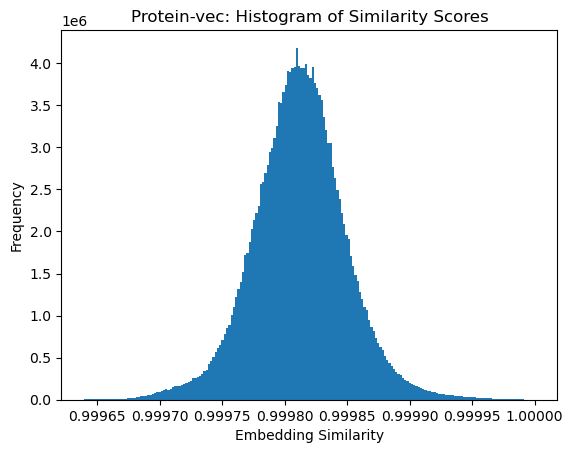

In [3]:
sims = np.stack([query['S_i'] for query in data], axis=0)
plt.hist(sims.flatten(), bins=200)
plt.xlabel('Embedding Similarity')
plt.ylabel('Frequency')
plt.title('Protein-vec: Histogram of Similarity Scores')
# plt.show()
# plt.savefig('/data/ron/protein-conformal/data/pvec_histogram.pdf', format='pdf')

In [4]:
# get the 20th, 40th, 60th, 80th percentiles of the similarity scores
percentiles = [20, 50, 80, 99]
percentile_values = np.percentile(sims.flatten(), percentiles)
print(percentile_values)

[0.9997831  0.99981213 0.99984044 0.99990904]


## Test for exchangability

In [5]:
source_data_path = '/groups/doudna/projects/ronb/conformal_backup/protein-conformal/'
protein_date_cutoff = np.load(source_data_path + 'data/new_proteins_after_cutoff.npy', allow_pickle=True)
print(data[protein_date_cutoff].shape)

(870,)


In [10]:
# calculate risk for every datapoint above a certain threshold lambda
labels = np.stack([query['exact'] for query in data[protein_date_cutoff]], axis=0)
sims = np.stack([query['S_i'] for query in data[protein_date_cutoff]], axis=0)
print(labels.shape)
print(sims.shape)

(870, 100000)
(870, 100000)


In [11]:
labels_after = np.stack([query['exact'] for query in data[~protein_date_cutoff]], axis=0)
sims_after = np.stack([query['S_i'] for query in data[~protein_date_cutoff]], axis=0)
print(labels_after.shape)
print(sims_after.shape)

(994, 100000)
(994, 100000)


In [12]:
def risk_1d(sims, labels, lam):
    # FDR: Number of false matches / number of matches
    total_discoveries = (sims >= lam).sum()
    false_discoveries = ((1 - labels) * (sims >= lam)).sum()
    total_discoveries = np.maximum(total_discoveries, 1)
    fdr = false_discoveries / total_discoveries
    return fdr

In [13]:
lam = 0.9999520198675599
# calculate risk for every datapoint
risks_before = [risk_1d(sims[i], labels[i], lam) for i in range(len(labels))]
risks_after = [risk_1d(sims_after[i], labels_after[i], lam) for i in range(len(labels_after))]

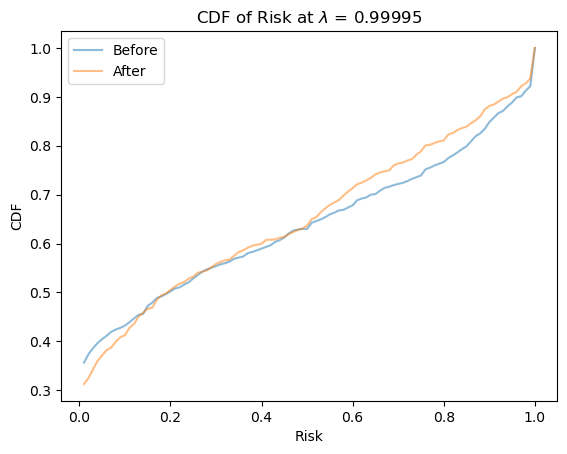

In [14]:
# Compute histogram for risks_before
counts_before, bin_edges_before = np.histogram(risks_before, bins=100, density=True)
cdf_before = np.cumsum(counts_before)  # Cumulative sum
cdf_before = cdf_before / cdf_before[-1]  # Normalize to turn it into a proper CDF

# Compute histogram for risks_after
counts_after, bin_edges_after = np.histogram(risks_after, bins=100, density=True)
cdf_after = np.cumsum(counts_after)  # Cumulative sum
cdf_after = cdf_after / cdf_after[-1]  # Normalize to turn it into a proper CDF

# Plot CDFs
plt.plot(bin_edges_before[1:], cdf_before, label='Before', alpha=0.5)
plt.plot(bin_edges_after[1:], cdf_after, label='After', alpha=0.5)

# Add labels and title
plt.xlabel('Risk')
plt.ylabel('CDF')
plt.legend()
plt.title(rf'CDF of Risk at $\lambda$ = {lam:.5f}')
plt.show()

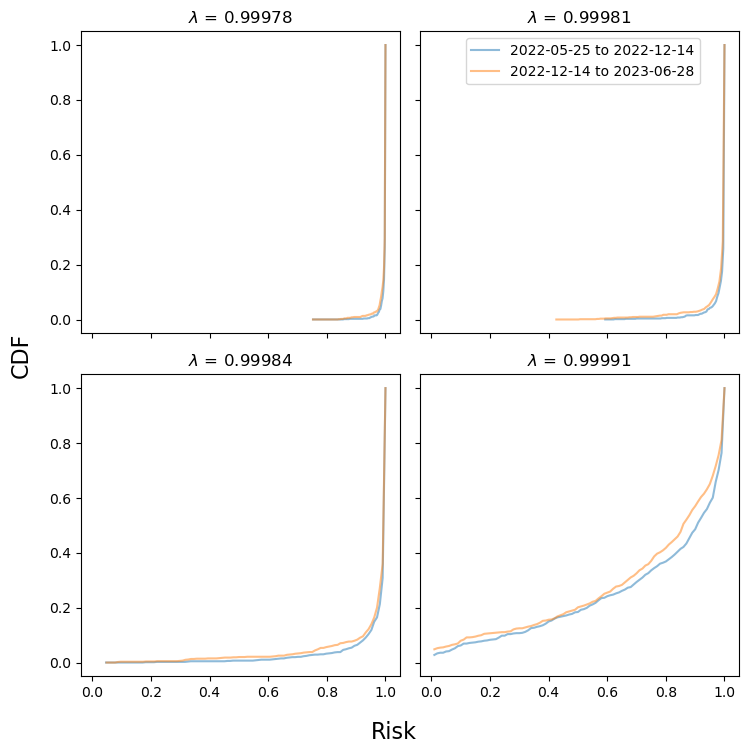

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the 2x2 array for easier indexing

for idx, lam in enumerate(percentile_values):
    risks_before = [risk_1d(sims[i], labels[i], lam) for i in range(len(labels))]
    risks_after = [risk_1d(sims_after[i], labels_after[i], lam) for i in range(len(labels_after))]

    # Compute histogram for risks_before
    counts_before, bin_edges_before = np.histogram(risks_before, bins=100, density=True)
    cdf_before = np.cumsum(counts_before)  # Cumulative sum
    cdf_before = cdf_before / cdf_before[-1]  # Normalize to turn it into a proper CDF

    # Compute histogram for risks_after
    counts_after, bin_edges_after = np.histogram(risks_after, bins=100, density=True)
    cdf_after = np.cumsum(counts_after)  # Cumulative sum
    cdf_after = cdf_after / cdf_after[-1]  # Normalize to turn it into a proper CDF

    # Plot CDFs
    ax = axes[idx]
    ax.plot(bin_edges_before[1:], cdf_before, label='2022-05-25 to 2022-12-14', alpha=0.5)
    ax.plot(bin_edges_after[1:], cdf_after, label='2022-12-14 to 2023-06-28', alpha=0.5)

    # Set title
    ax.set_title(rf'$\lambda$ = {lam:.5f}')
    
    # Remove inner labels to declutter the plots
    ax.label_outer()

    # Add legend to the top-right subplot (index 1)
    if idx == 1:
            ax.legend(loc='upper right', bbox_to_anchor=(0.9, 1))  # Shift legend to the left

# Add labels and legend
# axes[-1].set_xlabel('Risk', fontsize=12)  # Set x-label on the last subplot
# axes[0].set_ylabel('CDF', fontsize=12)    # Set y-label on the first subplot

fig.text(0.02, 0.5, 'CDF', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 0.02, 'Risk', ha='center', fontsize=16)  # Larger label for Risk

# Add a single legend for all subplots
# handles, labels_fig = ax.get_legend_handles_labels()
# fig.legend(handles, labels_fig, loc='', ncol=2, bbox_to_anchor=(0.5, -0.05))

# Adjust layout to make space for the new labels and ensure plots fit well
fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

# Show the plot (uncomment in a script or notebook)
# plt.show()
plt.savefig(source_data_path + '/data/risk_cdf.pdf', format='pdf')

No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives


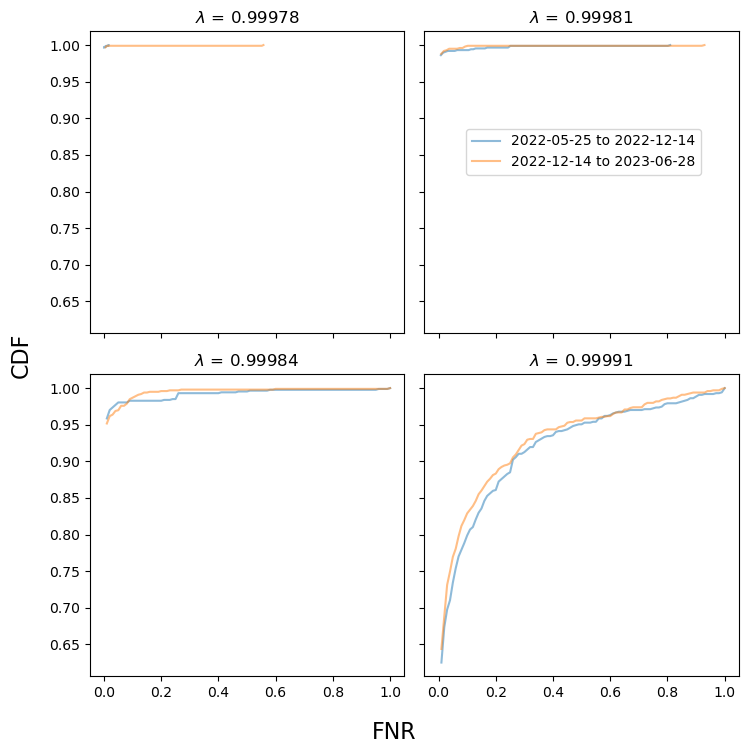

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the 2x2 array for easier indexing

for idx, lam in enumerate(percentile_values):
    risks_before = [calculate_false_negatives(sims[i], labels[i], lam) for i in range(len(labels))]
    risks_after = [calculate_false_negatives(sims_after[i], labels_after[i], lam) for i in range(len(labels_after))]

    # Compute histogram for risks_before
    counts_before, bin_edges_before = np.histogram(risks_before, bins=100, density=True)
    cdf_before = np.cumsum(counts_before)  # Cumulative sum
    cdf_before = cdf_before / cdf_before[-1]  # Normalize to turn it into a proper CDF

    # Compute histogram for risks_after
    counts_after, bin_edges_after = np.histogram(risks_after, bins=100, density=True)
    cdf_after = np.cumsum(counts_after)  # Cumulative sum
    cdf_after = cdf_after / cdf_after[-1]  # Normalize to turn it into a proper CDF

    # Plot CDFs
    ax = axes[idx]
    ax.plot(bin_edges_before[1:], cdf_before, label='2022-05-25 to 2022-12-14', alpha=0.5)
    ax.plot(bin_edges_after[1:], cdf_after, label='2022-12-14 to 2023-06-28', alpha=0.5)

    # Set title
    ax.set_title(rf'$\lambda$ = {lam:.5f}')
    
    # Add legend to the top-right subplot (index 1)
    if idx == 1:
            ax.legend(loc='upper right', bbox_to_anchor=(0.9, .7))  # Shift legend to the left

    # Remove inner labels to declutter the plots
    ax.label_outer()

# Add labels and legend
# axes[-1].set_xlabel('Risk', fontsize=12)  # Set x-label on the last subplot
# axes[0].set_ylabel('CDF', fontsize=12)    # Set y-label on the first subplot

fig.text(0.02, 0.5, 'CDF', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 0.02, 'FNR', ha='center', fontsize=16)  # Larger label for Risk

# Add a single legend for all subplots
# handles, labels_fig = ax.get_legend_handles_labels()
# fig.legend(handles, labels_fig, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

# Adjust layout to make space for the new labels and ensure plots fit well
fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

# Show the plot (uncomment in a script or notebook)
# plt.show()
plt.savefig(source_data_path + '/data/fnr_cdf.pdf', format='pdf')

(array([31.28772636,  1.20724346,  1.81086519,  1.71026157,  1.10663984,
         1.10663984,  0.50301811,  1.20724346,  0.9054326 ,  0.40241449,
         1.50905433,  0.80482897,  1.50905433,  0.80482897,  0.80482897,
         0.20120724,  1.60965795,  0.9054326 ,  0.40241449,  0.70422535,
         0.70422535,  0.60362173,  0.30181087,  0.70422535,  0.40241449,
         0.80482897,  0.20120724,  0.30181087,  0.60362173,  0.70422535,
         0.40241449,  0.30181087,  0.20120724,  0.80482897,  0.70422535,
         0.40241449,  0.50301811,  0.40241449,  0.20120724,  0.20120724,
         0.80482897,  0.        ,  0.10060362,  0.30181087,  0.20120724,
         0.60362173,  0.40241449,  0.40241449,  0.30181087,  0.60362173,
         1.30784708,  0.40241449,  1.00603622,  0.80482897,  0.70422535,
         0.50301811,  0.50301811,  0.9054326 ,  0.80482897,  0.70422535,
         0.80482897,  0.30181087,  0.50301811,  0.50301811,  0.70422535,
         0.40241449,  0.20120724,  0.20120724,  1.0

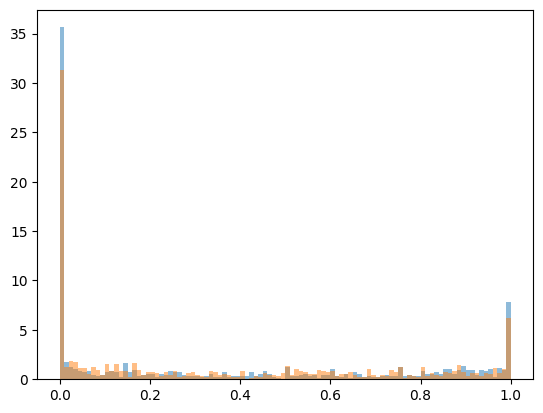

In [32]:
# normalize by density
# weights = np.ones_like(risks_before)/float(len(risks_before))
plt.hist(risks_before, 
         bins=100,
        #  weights=weights, 
         alpha=0.5, 
         label='Before', 
         density=True)

# weights = np.ones_like(risks_after)/float(len(risks_after))
plt.hist(risks_after,
            bins=100,
            # weights=weights, 
            alpha=0.5, 
            label='After',
            density=True)

In [22]:
# testing FNR for the same threshold
# fnr = [calculate_false_negatives(sims, labels, lam) for lam in lambdas]
lam = 0.999920198675599
fnr_before = [calculate_false_negatives(sims[i], labels[i], lam) for i in range(len(labels))]
fnr_after = [calculate_false_negatives(sims_after[i], labels_after[i], lam) for i in range(len(labels_after))]

No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives
No actual positives


(array([54.42655936,  5.23138833,  3.52112676,  2.81690141,  2.21327968,
         1.50905433,  1.30784708,  1.30784708,  1.60965795,  1.10663984,
         0.50301811,  0.50301811,  0.70422535,  0.80482897,  0.50301811,
         1.10663984,  0.80482897,  0.70422535,  0.9054326 ,  0.70422535,
         0.60362173,  0.50301811,  0.50301811,  0.40241449,  0.30181087,
         0.9054326 ,  0.50301811,  0.40241449,  0.20120724,  0.20120724,
         0.60362173,  0.20120724,  0.60362173,  0.60362173,  0.20120724,
         0.40241449,  0.20120724,  0.30181087,  0.60362173,  0.20120724,
         0.20120724,  0.50301811,  0.10060362,  0.30181087,  0.30181087,
         0.10060362,  0.10060362,  0.30181087,  0.        ,  0.        ,
         0.40241449,  0.40241449,  0.10060362,  0.10060362,  0.10060362,
         0.30181087,  0.10060362,  0.        ,  0.20120724,  0.10060362,
         0.        ,  0.10060362,  0.10060362,  0.10060362,  0.10060362,
         0.10060362,  0.50301811,  0.10060362,  0.2

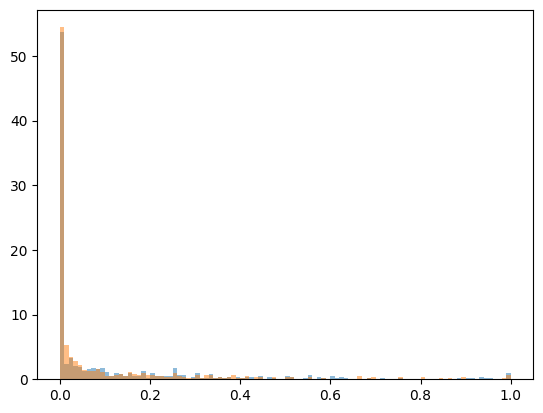

In [48]:
# weights = np.ones_like(risks_before)/float(len(risks_before))
plt.hist(fnr_before, 
         bins=100,
        #  weights=weights, 
         alpha=0.5, 
         label='Before', 
         density=True)

# weights = np.ones_like(risks_after)/float(len(risks_after))
plt.hist(fnr_after,
            bins=100,
            # weights=weights, 
            alpha=0.5, 
            label='After',
            density=True)

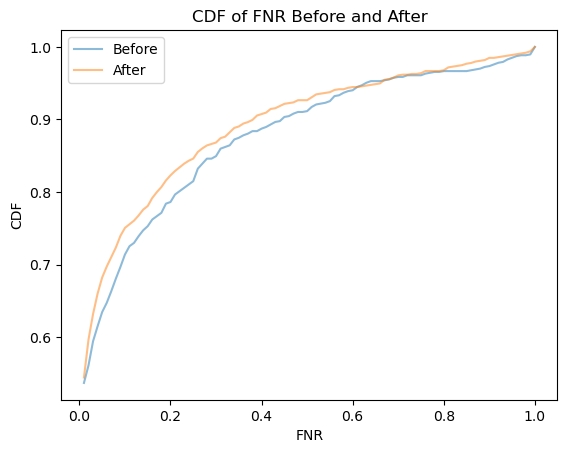

In [23]:
# Compute histogram for risks_before
counts_before, bin_edges_before = np.histogram(fnr_before, bins=100, density=True)
cdf_before = np.cumsum(counts_before)  # Cumulative sum
cdf_before = cdf_before / cdf_before[-1]  # Normalize to turn it into a proper CDF

# Compute histogram for risks_after
counts_after, bin_edges_after = np.histogram(fnr_after, bins=100, density=True)
cdf_after = np.cumsum(counts_after)  # Cumulative sum
cdf_after = cdf_after / cdf_after[-1]  # Normalize to turn it into a proper CDF

# Plot CDFs
plt.plot(bin_edges_before[1:], cdf_before, label='Before', alpha=0.5)
plt.plot(bin_edges_after[1:], cdf_after, label='After', alpha=0.5)

# Add labels and title
plt.xlabel('FNR')
plt.ylabel('CDF')
plt.legend()
plt.title('CDF of FNR Before and After')

plt.show()

In [39]:
len(fnr_before)

870

In [38]:
len(fnr_after)

994

In [33]:
# testing the hypothesis that the two samples come from the same distribution
from scipy.stats import ks_2samp
ks_2samp(risks_before, risks_after)


KstestResult(statistic=0.05137954161752122, pvalue=0.16489701173506632)

## FDR for exact hits on Pfam

In [4]:
# sims, labels = get_sims_labels(data, partial=False)
labels = np.stack([query['exact'] for query in data], axis=0)
sims = np.stack([query['S_i'] for query in data], axis=0)

In [5]:
labels.shape, sims.shape

((1864, 100000), (1864, 100000))

In [12]:
np.sum(labels, axis=0)

array([1508, 1456, 1380, ...,    0,    0,    0])

In [6]:
lambdas = np.linspace(sims.min(),sims.max(),100)
risks = [risk(sims, labels, lam) for lam in lambdas]
risks_no_empties = [risk_no_empties(sims, labels, lam) for lam in lambdas]
# no_empties: as we increase lambda, the number of empty sets increases. We filter out the empty sets and calculate the risk.
fnr = [calculate_false_negatives(sims, labels, lam) for lam in lambdas]
# percentage_of_discoveries_rsk = [percentage_of_discoveries(sims, labels, lam) for lam in lambdas]

In [7]:
np.max(fnr)

0.9999603121056015

In [8]:
# Plot FDR + FNR as a function of lambda
plt.figure(figsize=(3.5, 2.5))
plt.plot(lambdas, risks, label='Marginal risk')
# plt.plot(lambdas, risks_no_empties, label='Risk (no empty sets)')
# plt.plot(lambdas, percentage_of_discoveries_rsk, label='Percentage of discoveries')
plt.plot(lambdas, fnr, label='False negative rate')
# Customize the plot
plt.xlabel(r'Threshold $\lambda$', fontsize=10)
plt.ylabel('Error rate', fontsize=10)
plt.title(r'Error rates across $\lambda$ thresholds', fontsize=14)

# Adjust x-ticks to make the x-axis less crowded
plt.xticks(np.linspace(np.min(lambdas), np.max(lambdas), 3), [f'{x:.5f}' for x in np.linspace(np.min(lambdas), np.max(lambdas), 3)], fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
# Customize grid and remove top and right spines
plt.grid(True, linestyle='--', alpha=0.6)
sns.despine()
plt.savefig('/data/ron/protein-conformal/figs/pfam_new/pvec_error_rates.pdf', format='pdf', bbox_inches='tight')

## FDR / FNR on partial hits on Pfam

In [28]:
# Plot FDR as a function of lambda
sims, labels_partial = get_sims_labels(data, partial=True)
# labels_partial = np.stack([(np.sum(query['partial'], axis=1) >= 1) if len(np.array(query['partial']).shape) > 1 else query['partial'] for query in data], axis=0)
# sims = np.stack([query['S_i'] for query in data], axis=0)
lambdas = np.linspace(sims.min(),sims.max(),100)
risks = [risk(sims, labels_partial, lam) for lam in lambdas]
risks_no_empties = [risk_no_empties(sims, labels_partial, lam) for lam in lambdas]
# no_empties: as we increase lambda, the number of empty sets increases. We filter out the empty sets and calculate the risk.
fnr = [calculate_false_negatives(sims, labels_partial, lam) for lam in lambdas]

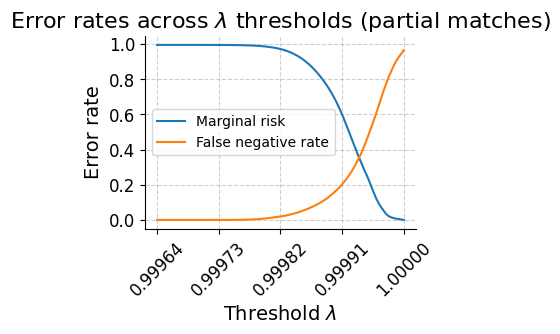

In [31]:
# Plot FDR + FNR as a function of lambda
plt.figure(figsize=(3.5, 2.5))
plt.plot(lambdas, risks, label='Marginal risk')
# plt.plot(lambdas, risks_no_empties, label='Risk (no empty sets)')
# plt.plot(lambdas, percentage_of_discoveries_rsk, label='Percentage of discoveries')
plt.plot(lambdas, fnr, label='False negative rate')
plt.xlabel(r'Threshold $\lambda$', fontsize=10)
plt.ylabel('Error rate', fontsize=10)
plt.title(r'Error rates across $\lambda$ thresholds (partial match)', fontsize=14)
# Adjust x-ticks to make the x-axis less crowded
plt.xticks(np.linspace(np.min(lambdas), np.max(lambdas), 5), [f'{x:.5f}' for x in np.linspace(np.min(lambdas), np.max(lambdas), 5)], fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
sns.despine()
plt.savefig('/data/ron/protein-conformal/figs/pfam_new/pvec_error_rates_partial.pdf', format='pdf')

## Learn then test for FDR

In [36]:
alpha = 0.1
lhat, risk_0 = get_thresh_FDR(labels, sims, alpha, delta=0.5, N=100)
print(f'alpha={alpha}, lhat={lhat}, risk={risk_0}')

alpha=0.1, lhat=0.9999820198675599, risk=0.07214881222814735


In [45]:
risks = []
tprs = []
lhats = []
fdr_cals = []
alpha = 0.1
num_trials = 100
n_calib = 100
for trial in tqdm(range(num_trials)):
    np.random.shuffle(data)
    cal_data = data[:n_calib]
    test_data = data[n_calib:2*n_calib]
    X_cal, y_cal = get_sims_labels(cal_data, partial=False)
    X_test, y_test_exact = get_sims_labels(test_data, partial=False)
    # sims, labels = get_sims_labels(cal_data, partial=False)
    lhat, fdr_cal = get_thresh_FDR(y_cal, X_cal, alpha, delta=0.5, N=100)
    fdr_cals.append(fdr_cal)
    lhats.append(lhat)
    # print(X_test.shape)
    # print(y_test_exact.shape)
    risks.append(risk(X_test, y_test_exact, lhat))
    tprs.append(calculate_true_positives(X_test, y_test_exact, lhat))
    # print(lhat)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [09:33<00:00,  5.73s/it]


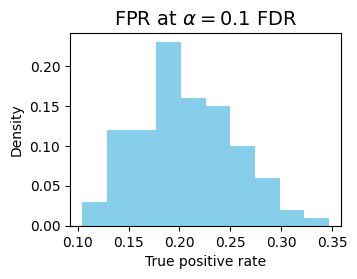

In [91]:
plt.figure(figsize=(3.5, 2.5))
weights = np.ones_like(risks)/float(len(risks))
plt.hist(np.array(tprs), weights=weights, color='skyblue')
plt.xlabel('True positive rate', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title(rf'FPR at $\alpha={alpha}$ FDR', fontsize=14)
plt.savefig('/data/ron/protein-conformal/figs/pfam_new/tpr_fdr.pdf', format='pdf', bbox_inches='tight')

In [69]:
plt.figure(figsize=(3.5, 2.5))
plt.hist(np.array(lhats), color='skyblue')
plt.xlabel('Threshold')
plt.ylabel('Density')
plt.title('Protein-vec: Histogram of Thresholds')

Text(0.5, 1.0, 'Protein-vec: Histogram of Thresholds')

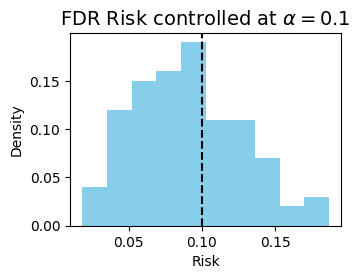

In [89]:
plt.figure(figsize=(3.5, 2.5))
weights = np.ones_like(risks)/float(len(risks))
plt.hist(np.array(risks), weights=weights, label='Risk', color='skyblue')
plt.axvline(alpha, color='black', linestyle='--')
plt.xlabel('Risk', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title(rf'FDR Risk controlled at $\alpha={alpha}$', fontsize=14)
plt.savefig('/data/ron/protein-conformal/figs/pfam_new/fdr_control.pdf', format='pdf', bbox_inches='tight')

### FNR

In [9]:
num_trials = 100
alpha = 0.1
n_calib = 100
fnrs = []
retrieved_data_percentages = []
for trial in tqdm(range(num_trials)):
    # Randomly split data into calibration and test sets
    np.random.shuffle(data)
    cal_data = data[:n_calib]
    test_data = data[n_calib:3*n_calib]

    # lhat = get_thresh_new(cal_data, alpha)
    # lhat = get_thresh(cal_data, alpha)
    # error, fraction_inexact, error_partial, fraction_partial = validate_lhat(test_data, lhat)

    # TODO: add lhat to print
    # TODO: difference between get_thresh and get_thresh_FDR
    # print(f'Trial {trial+1}: lhat: {lhat}, Ex&!Id/Ex: {error:.2f}, In/Id: {fraction_inexact:.2f}, Pa&!Id/Pa: {error_partial:.2f}, Pa&Id/Id: {fraction_partial:.2f}')

    X_cal, y_cal = get_sims_labels(cal_data, partial=False)
    X_test, y_test_exact = get_sims_labels(test_data, partial=False)
    _, y_test_partial = get_sims_labels(test_data, partial=True)
    lhat = get_thresh_new(X_cal, y_cal, alpha)
    error, fraction_inexact, error_partial, fraction_partial, fpr = validate_lhat_new(X_test, y_test_partial, y_test_exact, lhat)
    # print(f'Trial {trial+1}: lhat: {lhat}, Ex&!Id/Ex (FNR): {error:.2f}, In/Id (FDR): {fraction_inexact:.2f}, Pa&!Id/Pa (FNR partial): {error_partial:.2f}, Pa&Id/Id: {fraction_partial:.2f} (TPR partial), FPR: {fpr:.2f}')
    fnrs.append(error)
    retrieved_data_percentages.append((X_test.flatten() >= lhat).sum() / len(X_test.flatten()))
    

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [05:36<00:00,  3.36s/it]


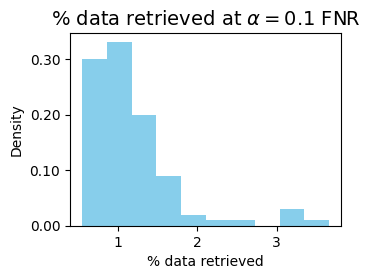

In [13]:
plt.figure(figsize=(3.5, 2.5))
weights = np.ones_like(retrieved_data_percentages)/float(len(retrieved_data_percentages))
plt.hist(np.array(retrieved_data_percentages) * 100, weights=weights, color='skyblue')
plt.xlabel('% data retrieved', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title(rf'% data retrieved at $\alpha={alpha}$ FNR', fontsize=14)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
plt.savefig('/data/ron/protein-conformal/figs/pfam_new/data_retrived.pdf', format='pdf', bbox_inches='tight')

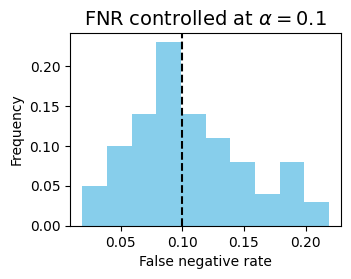

In [11]:
plt.figure(figsize=(3.5, 2.5))
weights = np.ones_like(fnrs)/float(len(fnrs))
plt.hist(np.array(fnrs), weights=weights, color='skyblue')
plt.axvline(alpha, color='black', linestyle='--')
plt.xlabel('False negative rate', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title(rf'FNR controlled at $\alpha={alpha}$', fontsize=14)
plt.savefig('/data/ron/protein-conformal/figs/pfam_new/fnr_control.pdf', format='pdf', bbox_inches='tight')


## Venn-Abers prediction

In [92]:
n_calib = 50

np.random.shuffle(data)
cal_data = data[:n_calib]
test_data = data[n_calib:3*n_calib]


X_cal, y_cal = get_sims_labels(cal_data, partial=False)
X_test, y_test_exact = get_sims_labels(test_data, partial=False)
# flatten the data
X_cal = X_cal.flatten()
y_cal = y_cal.flatten()
X_test = X_test.flatten()
y_test_exact = y_test_exact.flatten()


# np.random.shuffle(data)
# X_cal = sims[:n_calib, :].flatten()
# y_cal = labels[:n_calib].flatten()
# cal_data = data[:n_calib]
# X_test = sims[n_calib:2*n_calib, :].flatten()
# y_test = labels[n_calib:2*n_calib].flatten()
# test_data = data[n_calib:3*n_calib]
# ir = get_isotone_regression(cal_data)
# sims, labels = get_sims_labels(test_data, partial=False)
p_0, p_1 = simplifed_venn_abers_prediction(X_cal, y_cal, X_test[0])


In [93]:
p_0, p_1

(1.0, 0.9940594)

In [14]:
def run_trial(data, n_calib):
    np.random.shuffle(data)
    cal_data = data[:n_calib]
    test_data = data[n_calib:3*n_calib]
    X_cal, y_cal = get_sims_labels(cal_data, partial=False)
    X_test, y_test_exact = get_sims_labels(test_data, partial=False)
    # flatten the data
    X_cal = X_cal.flatten()
    y_cal = y_cal.flatten()
    X_test = X_test.flatten()
    y_test_exact = y_test_exact.flatten()

    # generate random indices in the test set
    i = np.random.randint(0, len(X_test))
    # i_s = np.random.randint(0, len(X_test), int(len(X_test) * args.percent_sva_test))

    p_0, p_1 = simplifed_venn_abers_prediction(X_cal, y_cal, X_test[i])
    result = (p_0, p_1, X_test[i], y_test_exact[i])
    return result

num_trials = 1000
sva_results = []
n_calib = 50
for trial in tqdm(range(num_trials)):
    # print(f'Running trial {i+1} of {args.num_trials}')
    sva_results.append(run_trial(data, n_calib))

# sva_results = []
# # generate random indices in the test set
# i_s = np.random.randint(0, len(X_test), 10000)

# for _, i in tqdm(enumerate(i_s)):
#     p_0, p_1 = simplifed_venn_abers_prediction(X_cal, y_cal, X_test[i])
#     sva_results.append((p_0, p_1, y_test_exact[i]))
    # print(f'Prediction: {p_1}, Actual: {y_test[i]}')

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [15:42<00:00,  1.06it/s]


In [16]:
abs_p = [np.abs(p[0] - p[1]) for p in sva_results]

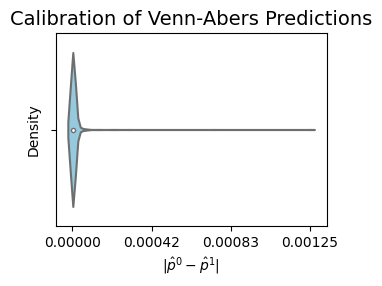

In [24]:
plt.figure(figsize=(3.5, 2.5))
# weights = np.ones_like(abs_p) / len(abs_p)
# plt.hist(abs_p, bins=50, color='skyblue', weights=weights)
sns.violinplot(x=abs_p, color='skyblue')
plt.xlabel(r'$|\hat{p}^0 - \hat{p}^1|$', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.title('Calibration of Venn-Abers Predictions', fontsize=14)
# plt.xticks(fontsize=10)
x_ticks = np.linspace(min(abs_p), max(abs_p), num=4)
plt.xticks(x_ticks, [f'{tick:.5f}' for tick in x_ticks], fontsize=10)
plt.yticks(fontsize=10)
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.savefig('/data/ron/protein-conformal/figs/sva_calibration.pdf', format='pdf')
plt.savefig('/data/ron/protein-conformal/figs/pfam_new/sva_calibration.pdf', format='pdf', bbox_inches='tight')

<Figure size 350x250 with 0 Axes>

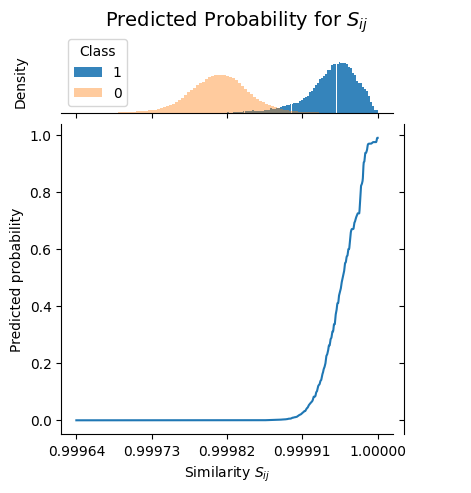

In [120]:
num_trials = 1
n_calib = 1000
for trial in range(num_trials):
    # Randomly split data into calibration and test sets
    np.random.shuffle(data)
    cal_data = data[:n_calib]
    test_data = data[n_calib:2*n_calib]
    X_cal, y_cal = get_sims_labels(cal_data, partial=False)
    ir = get_isotone_regression(X_cal.flatten(), y_cal.flatten())
    X_test, y_test = get_sims_labels(test_data, partial=False)
    preds = ir.predict(X_test.flatten())

    plt.figure(figsize=(3.5, 2.5))
    g = sns.JointGrid(height=5, ratio=5, space=0.2)
    # g.ax_joint.scatter(X_test[y_test], y_test[y_test], alpha=0.002)
    # g.ax_joint.scatter(X_test[~y_test], y_test[~y_test], alpha=0.002)
    x = np.linspace(np.min(X_test), np.max(X_test), 1000)

    phats = ir.predict(x)
    g.ax_joint.plot(x, phats)
    g.set_axis_labels(r'Similarity $S_{ij}$', 'Predicted probability', fontsize=10)

    weights_1 = np.ones_like(y_test[y_test]) / len(y_test[y_test])
    g.ax_marg_x.hist(X_test[y_test], label='1', alpha=0.9, bins=100, density=True, weights=weights_1)

    weights_0 = np.ones_like(y_test[~y_test]) / len(y_test[~y_test])
    g.ax_marg_x.hist(X_test[~y_test], label='0', alpha=0.4, bins=100, density=True, weights=weights_0)
    # Manually create a new axis for the marginal histogram and set its y-axis label
    ax_marg_y = g.figure.add_axes(g.ax_marg_x.get_position())
    ax_marg_y.yaxis.tick_right()
    # ax_marg_y.set_ylabel('Density', labelpad=15, fontsize=10)
    ax_marg_y.set_ylabel('Density', fontsize=10)
    ax_marg_y.yaxis.set_label_position('left')
    ax_marg_y.set_yticks([])
    ax_marg_y.set_frame_on(False)
    ax_marg_y.set_xticks([])

    # Set fewer x-axis ticks
    x_ticks = np.linspace(np.min(X_test), np.max(X_test), 5)
    g.ax_joint.set_xticks(x_ticks)
    g.ax_joint.set_xticklabels([f'{tick:.5f}' for tick in x_ticks], fontsize=10)

    handles, labels = g.ax_marg_x.get_legend_handles_labels()
    g.ax_marg_x.legend(handles, labels, title='Class')

    # Optionally remove the spines for a cleaner look
    # g.ax_marg_x.spines['bottom'].set_visible(False)
    # g.ax_marg_x.spines['top'].set_visible(False)
    # g.ax_marg_x.spines['left'].set_visible(False)
    # g.ax_marg_x.spines['right'].set_visible(False)
    
    plt.suptitle(r'Predicted Probability for $S_{ij}$', y=1.05, fontsize=14)
    # Adjust subplots to fit the figure size
    plt.subplots_adjust(left=0.15, right=0.95, top=.95, bottom=0.2)
    plt.savefig('/data/ron/protein-conformal/figs/pfam_new/isotonic_regression.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    
    ##print()
    #plt.figure()
    #sim_bins = np.linspace(min(sims), max(sims), 100)
    #plt.hist(np.array(sims)[np.array(labels)], bins=sim_bins, alpha=0.5, label='1')
    #plt.hist(np.array(sims)[~np.array(labels)], bins=sim_bins, alpha=0.5, label='0')
    #plt.legend()

    